# Colab-latent-composition 
Original repo: [chail/latent-composition](https://github.com/chail/latent-composition)

Original colab: [here](https://github.com/chail/latent-composition/blob/main/notebooks/quickstart.ipynb)

My fork: [Colab-latent-composition](https://github.com/styler00dollar/Colab-latent-composition)

Making a more compact and colab-friendly version by using ``@title`` and fixing dependencies. If you want to play around with own images, use [Colab-latent-composition.ipynb](https://colab.research.google.com/github/styler00dollar/Colab-latent-composition/blob/main/Colab-latent-composition.ipynb). This colab is just the quickstart demo.

In [ ]:
!nvidia-smi

In [ ]:
#@title install
!git clone https://github.com/chail/latent-composition
%cd /content/latent-composition
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
import torch
from networks import networks
from PIL import Image
from utils import show, renormalize, compositions, masking, imutil
import matplotlib.pyplot as plt
import numpy as np
import os
!pip install ninja
!pip install prdc
%cd /content/
!wget https://raw.githubusercontent.com/rosinality/id-gan-pytorch/master/stylegan2/op/fused_bias_act.cpp
!wget https://raw.githubusercontent.com/rosinality/id-gan-pytorch/master/stylegan2/op/fused_bias_act_kernel.cu
!cd /content/latent-composition
!sh resources/download_resources.sh

In [ ]:
#@title fused_act.py (fixing module load)
%%writefile /content/latent-composition/utils/PT_STYLEGAN2/op/fused_act.py
import os

import torch
from torch import nn
from torch.autograd import Function
from torch.utils.cpp_extension import load


module_path = os.path.dirname(__file__)
"""
fused = load(
    name='fused',
    sources=[
        '/content/fused_bias_act.cpp',
        '/content/fused_bias_act_kernel.cu',
    ],
)
"""
#https://github.com/rosinality/id-gan-pytorch/tree/master/stylegan2/op
from torch.utils.cpp_extension import BuildExtension, CppExtension
fused = load(
    name='fused_bias_act',
    sources=[
        '/content/fused_bias_act.cpp',
        '/content/fused_bias_act_kernel.cu',
    ],
)

class FusedLeakyReLUFunctionBackward(Function):
    @staticmethod
    def forward(ctx, grad_output, out, negative_slope, scale):
        ctx.save_for_backward(out)
        ctx.negative_slope = negative_slope
        ctx.scale = scale

        empty = grad_output.new_empty(0)

        grad_input = fused.fused_bias_act(
            grad_output, empty, out, 3, 1, negative_slope, scale
        )

        dim = [0]

        if grad_input.ndim > 2:
            dim += list(range(2, grad_input.ndim))

        grad_bias = grad_input.sum(dim).detach()

        return grad_input, grad_bias

    @staticmethod
    def backward(ctx, gradgrad_input, gradgrad_bias):
        out, = ctx.saved_tensors
        gradgrad_out = fused.fused_bias_act(
            gradgrad_input, gradgrad_bias, out, 3, 1, ctx.negative_slope, ctx.scale
        )

        return gradgrad_out, None, None, None


class FusedLeakyReLUFunction(Function):
    @staticmethod
    def forward(ctx, input, bias, negative_slope, scale):
        empty = input.new_empty(0)
        out = fused.fused_bias_act(input, bias, empty, 3, 0, negative_slope, scale)
        ctx.save_for_backward(out)
        ctx.negative_slope = negative_slope
        ctx.scale = scale

        return out

    @staticmethod
    def backward(ctx, grad_output):
        out, = ctx.saved_tensors

        grad_input, grad_bias = FusedLeakyReLUFunctionBackward.apply(
            grad_output, out, ctx.negative_slope, ctx.scale
        )

        return grad_input, grad_bias, None, None


class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()

        self.bias = nn.Parameter(torch.zeros(channel))
        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)


def fused_leaky_relu(input, bias, negative_slope=0.2, scale=2 ** 0.5):
    return FusedLeakyReLUFunction.apply(input, bias, negative_slope, scale)



In [ ]:
#@title load the GAN, encoder, and part extractor
gtype = 'stylegan'
domain = 'car'
nets = networks.define_nets(gtype, domain)
compositer = compositions.get_compositer(domain)(nets)


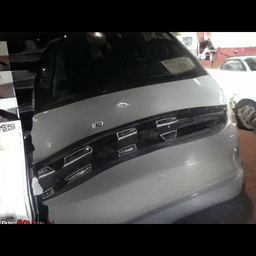
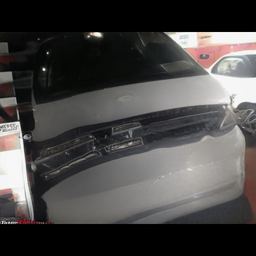


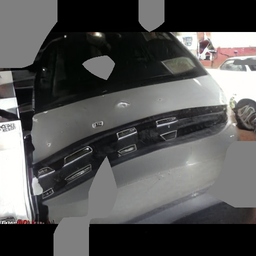
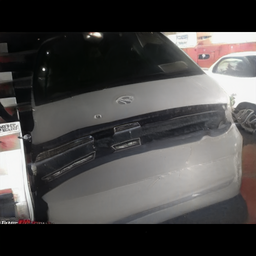

In [26]:
#@title visualize the reconstruction, and masked reconstruction
with torch.no_grad():
    im = nets.seed2image(1,seed=10)
    show.a(['Input Image', renormalize.as_image(im[0]).resize((256, 256), Image.ANTIALIAS)])
    rec = nets.invert(im, mask=None)
    show.a(['Reconstructed', renormalize.as_image(rec[0]).resize((256, 256), Image.ANTIALIAS)])
    show.flush()
    hints, mask = masking.mask_upsample(im, mask_cent=0.5 if gtype == 'proggan' else 0.)
    rec_mask = nets.invert(hints, mask=mask)
    show.a(['Input Masked', renormalize.as_image(hints[0]).resize((256, 256), Image.ANTIALIAS)])
    show.a(['Rec. Masked', renormalize.as_image(rec_mask[0]).resize((256, 256), Image.ANTIALIAS)])
    show.flush()

### randomly sample image parts, and compose them

In [28]:
rng = np.random.RandomState(0)
indices = rng.choice(compositer.total_samples,
                     len(compositer.ordered_labels))
with torch.no_grad():
    composite_data = compositer(indices)


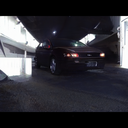
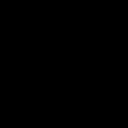
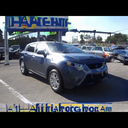
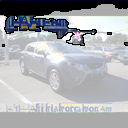
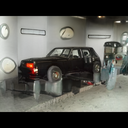
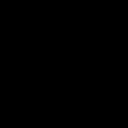


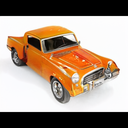
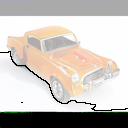
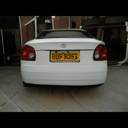
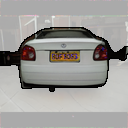

In [29]:
for im, m in zip(composite_data.parts_image, composite_data.parts_mask):
    show.a([renormalize.as_image(im).resize((128, 128), Image.ANTIALIAS)], cols=6)
    a, b, c = imutil.draw_masked_image(im[None], m[None], size=128)
    show.a([c], cols=6)
show.flush()


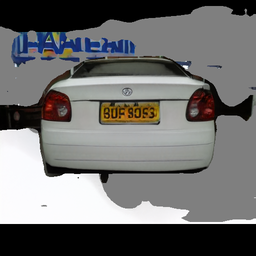
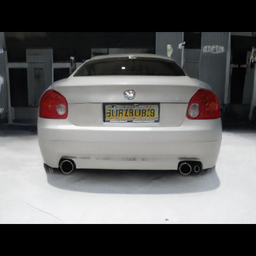

In [30]:
show.a(['Network Input', renormalize.as_image(composite_data.composite_image[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['Network Output', renormalize.as_image(composite_data.inverted_RGBM[0]).resize((256, 256), Image.ANTIALIAS)])
show.flush()